In [9]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib

     |████████████████████████████████| 7.2 MB 10.1 MB/s 
     |████████████████████████████████| 17.0 MB 9.0 MB/s 
     |████████████████████████████████| 11.3 MB 7.2 MB/s 
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp39-cp39-macosx_10_9_x86_64.whl (61 kB)
     |████████████████████████████████| 2.9 MB 6.2 MB/s 
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [1]:
# Define min trip length to sort out too short trips
MIN_TRIP_LENGTH = 1000

In [2]:
# Define labels found in the SHL documentation
# Note: There are coarse labels and fine labels
# but we'll only use coarse labels
COARSE_LABELS = {
    0: 'Null',
    1: 'Still',
    2: 'Walking',
    3: 'Run',
    4: 'Bike',
    5: 'Car',
    6: 'Bus',
    7: 'Train',
    8: 'Subway',
}

In [3]:
# The null label is irrelevant for our later classification
UNWANTED_LABELS = [ 'Null' ]

In [4]:
# Define motion columns found in the SHL documentation
MOTION_COLUMNS = [
    'Time',
    'Acceleration X',
    'Acceleration Y',
    'Acceleration Z',
    'Gyroscope X',
    'Gyroscope Y',
    'Gyroscope Z',
    'Magnetometer X',
    'Magnetometer Y',
    'Magnetometer Z',
    'Orientation w',
    'Orientation x',
    'Orientation y',
    'Orientation z',
    'Gravity X',
    'Gravity Y',
    'Gravity Z',
    'Linear acceleration X',
    'Linear acceleration Y',
    'Linear acceleration Z',
    'Pressure',
    'Altitude',
    'Temperature',
]

In [5]:
# Define label columns found in the SHL documentation
LABEL_COLUMNS = [
    'Time',
    'Coarse Label',
    'Fine Label',
    'Road Label',
    'Traffic Label',
    'Tunnels Label',
    'Social Label',
    'Food Label',
]

In [10]:
import pandas as pd

# Show only 2 digits in pandas table 
pd.set_option("display.precision", 2)

In [11]:
import re

from pathlib import Path

# Define constants and helpers to load and save files

release_dir = Path('shl/release')
records_dir = release_dir / 'User1'
record_dirs = [r for r in records_dir.iterdir() if r.is_dir()]

def load_motion_data(record_dir: Path) -> pd.DataFrame:
    motion_data = pd.read_csv(
        record_dir / 'Hips_Motion.txt',
        sep=' ',
        header=None,
        names=MOTION_COLUMNS,
        low_memory=False
    )
    return motion_data


def load_labels_data(record_dir: Path) -> pd.DataFrame:
    labels_data = pd.read_csv(
        record_dir / 'Label.txt',
        sep=' ',
        header=None,
        names=LABEL_COLUMNS,
        low_memory=False
    )
    labels_data.replace({
        'Coarse Label': COARSE_LABELS,
    }, inplace=True)
    return labels_data


def get_valid_filename(s):
    s = str(s).strip().replace(' ', '_').lower()
    return re.sub(r'(?u)[^-\w.]', '', s)

In [12]:
# Load all records and join them into a single pandas dataframe

joined_data = None

for record_dir in record_dirs:
    try:
        motion_data = load_motion_data(record_dir)
        labels_data = load_labels_data(record_dir)
    except FileNotFoundError:
        print(f'Missing file for dir {record_dir}')
        continue

    # In the documentation, it is said that every line
    # in Hips_Motion.txt corresponds to the exact same line
    # in Label.txt, therefore we can just merge them together
    try:
        data = pd.merge(motion_data, labels_data)
    except ValueError:
        print(f'Data under dir {record_dir} has erroneous format')
        continue

    # Drop rows that contain any NaN
    data.dropna(how='any', inplace=True)

    if joined_data is None:
        joined_data = data
    else:
        joined_data = joined_data.append(data)

    print(f'Loaded dataframe under dir {record_dir}')

# Drop columns that are all NaN
joined_data.dropna(axis='columns', how='all', inplace=True)

Loaded dataframe under dir shl/release/User1/030717
Loaded dataframe under dir shl/release/User1/010317
Loaded dataframe under dir shl/release/User1/030317
Loaded dataframe under dir shl/release/User1/020317
Loaded dataframe under dir shl/release/User1/060317
Loaded dataframe under dir shl/release/User1/040717
Loaded dataframe under dir shl/release/User1/050717
Loaded dataframe under dir shl/release/User1/030517
Loaded dataframe under dir shl/release/User1/020517
Data under dir shl/release/User1/050517 has erroneous format
Loaded dataframe under dir shl/release/User1/040517
Loaded dataframe under dir shl/release/User1/020617
Loaded dataframe under dir shl/release/User1/030617
Loaded dataframe under dir shl/release/User1/010617
Loaded dataframe under dir shl/release/User1/050617
Loaded dataframe under dir shl/release/User1/060617


In [13]:
# Give a quick overview about how our data is structured
joined_data_description = joined_data.describe()
print(joined_data_description)

           Time  Acceleration X  Acceleration Y  Acceleration Z  Gyroscope X  \
count  3.95e+07        3.95e+07        3.95e+07        3.95e+07     3.95e+07   
mean   1.49e+12        3.25e-01       -2.93e+00        1.05e+00     6.08e-03   
std    3.67e+09        4.76e+00        7.08e+00        6.93e+00     1.10e+00   
min    1.49e+12       -7.83e+01       -7.88e+01       -7.83e+01    -1.80e+01   
25%    1.49e+12       -1.92e+00       -9.14e+00       -3.33e+00    -2.57e-02   
50%    1.50e+12        3.09e-01       -1.54e+00        7.13e-01     5.03e-03   
75%    1.50e+12        2.74e+00        1.25e+00        7.11e+00     3.56e-02   
max    1.50e+12        7.84e+01        7.67e+01        7.84e+01     3.00e+01   

       Gyroscope Y  Gyroscope Z  Magnetometer X  Magnetometer Y  \
count     3.95e+07     3.95e+07        3.95e+07        3.95e+07   
mean      1.56e-03     1.01e-03       -1.65e+00        9.32e+00   
std       1.12e+00     5.70e-01        5.24e+01        5.37e+01   
min      -3

In [14]:
# Write the data description as a LateX table
with open('shl_data_description.tex', 'w') as f:
    f.write(joined_data_description.to_latex(
        float_format="{:0.2f}".format,
        decimal=',',
        caption='Datenattribute des SHL-Datensatzes.',
        label='tab:shl-analyse'
    ))

In [15]:
# Build a trip column that increments every time
# the label changes, for grouping
joined_data['Trip'] = joined_data['Coarse Label'].ne(
    joined_data['Coarse Label'].shift()
).cumsum()

In [16]:
from collections import defaultdict

# Order trips by their label for statistical evaluation
trips_by_label = defaultdict(list)
for trip_id, data in joined_data.groupby('Trip'):
    length, _ = data.shape
    if length < MIN_TRIP_LENGTH:
        print(f'Warning: Dropped trip {trip_id} because it was too short! (Height {length})')
        continue
    label = data['Coarse Label'].values[0]
    # Drop unwanted labels
    if label in UNWANTED_LABELS:
        continue
    trips_by_label[label].append(data)

<Figure size 432x288 with 0 Axes>

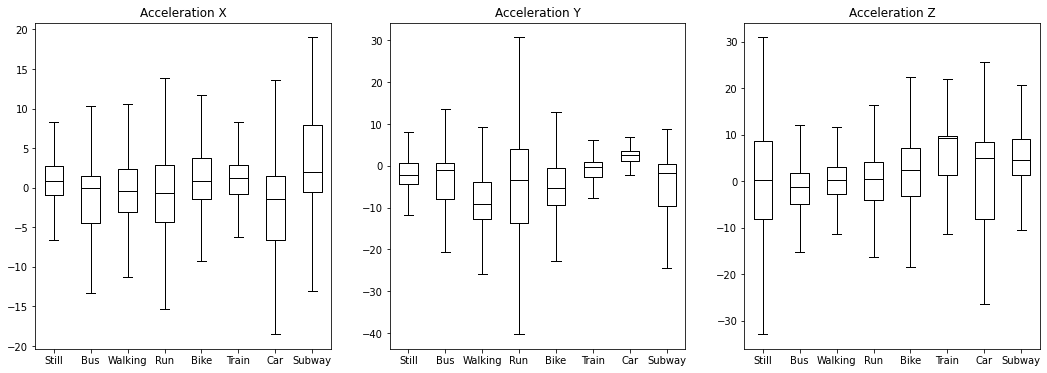

Computed statistics for sensor group Acceleration


<Figure size 432x288 with 0 Axes>

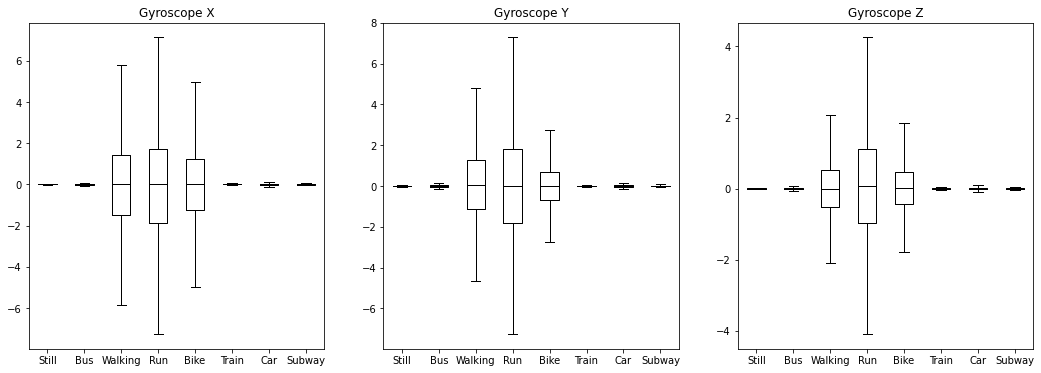

Computed statistics for sensor group Gyroscrope


<Figure size 432x288 with 0 Axes>

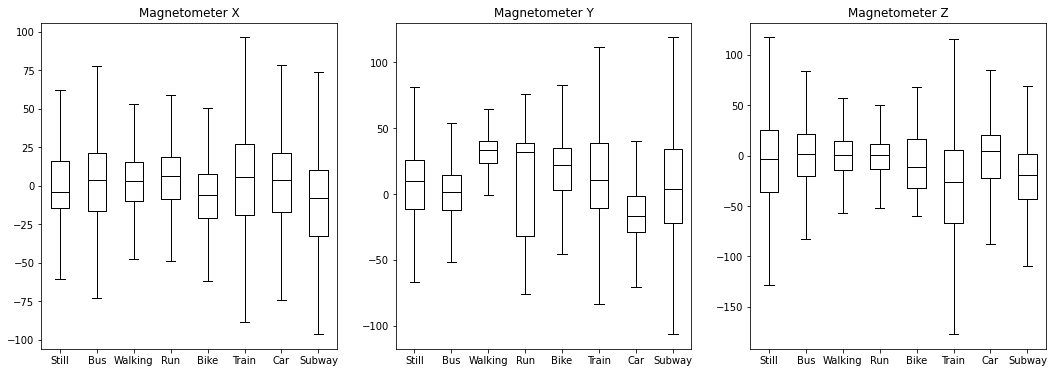

Computed statistics for sensor group Magnetometer


<Figure size 432x288 with 0 Axes>

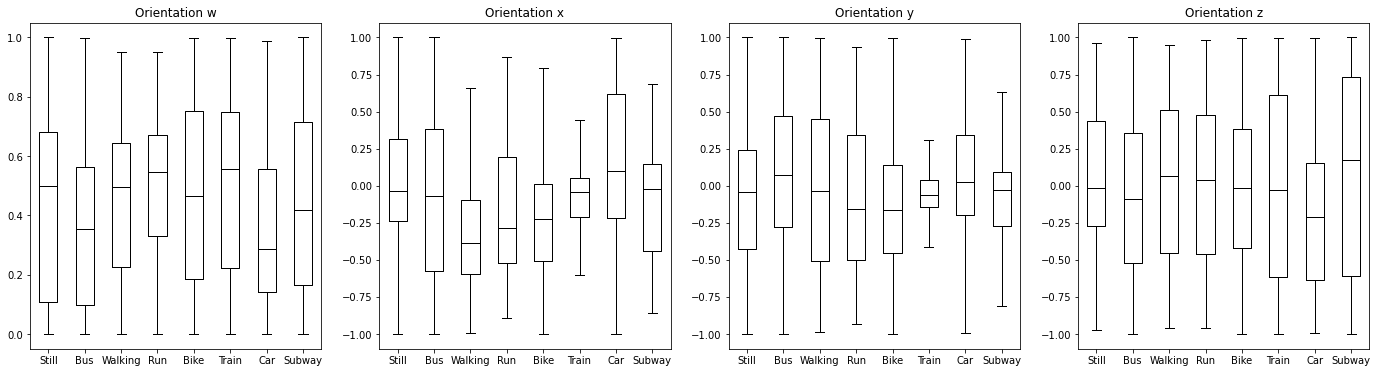

Computed statistics for sensor group Orientation


<Figure size 432x288 with 0 Axes>

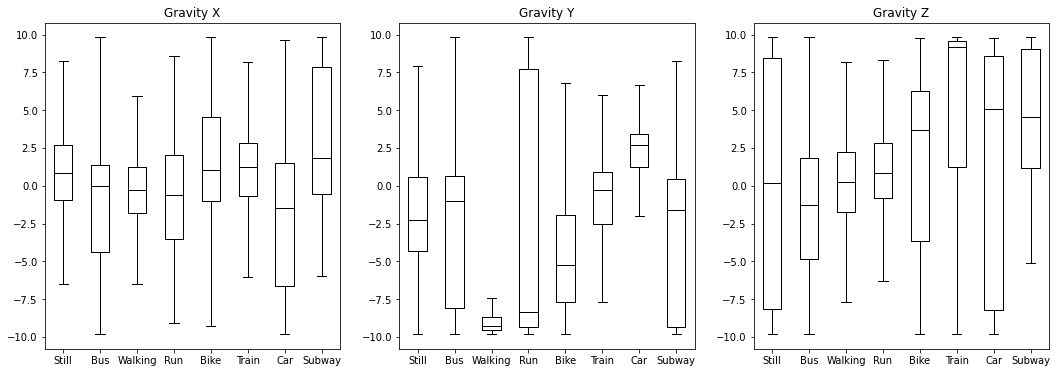

Computed statistics for sensor group Gravity


<Figure size 432x288 with 0 Axes>

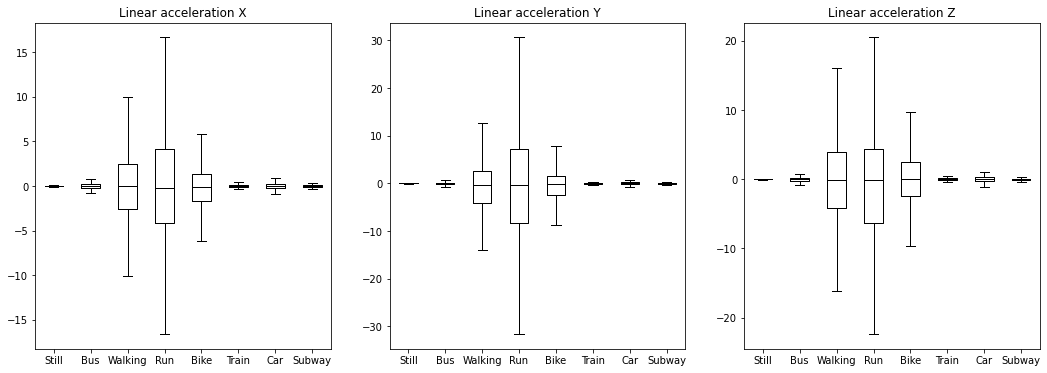

Computed statistics for sensor group Linear Acceleration


<Figure size 432x288 with 0 Axes>

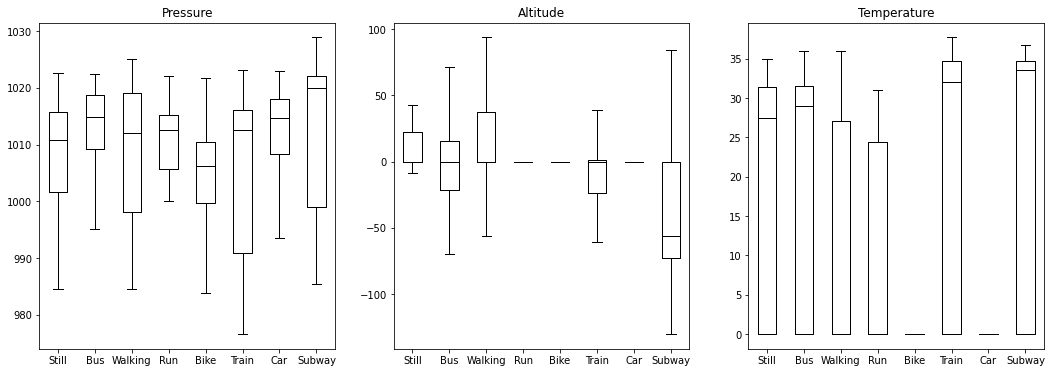

Computed statistics for sensor group Other


In [17]:
from collections import OrderedDict

import matplotlib.pyplot as plt

# Create boxplots for each sensor
# to show differences between labels

BOXPLOT_GROUPS = {
    'Acceleration': [
        'Acceleration X',
        'Acceleration Y',
        'Acceleration Z',
    ],
    'Gyroscrope': [
        'Gyroscope X',
        'Gyroscope Y',
        'Gyroscope Z',
    ],
    'Magnetometer': [
        'Magnetometer X',
        'Magnetometer Y',
        'Magnetometer Z',
    ],
    'Orientation': [
        'Orientation w',
        'Orientation x',
        'Orientation y',
        'Orientation z',
    ],
    'Gravity': [
        'Gravity X',
        'Gravity Y',
        'Gravity Z',
    ],
    'Linear Acceleration': [
        'Linear acceleration X',
        'Linear acceleration Y',
        'Linear acceleration Z',
    ],
    'Other': [
        'Pressure',
        'Altitude',
        'Temperature',
    ],
}

for sensor_group, sensors in BOXPLOT_GROUPS.items():
    plt.clf()
    fig, axs = plt.subplots(1, len(sensors))
    fig.set_size_inches(6 * len(sensors), 6)

    for i, sensor in enumerate(sensors):
        diagram_dict = OrderedDict()
        for label, trips in trips_by_label.items():
            # Concatenate individual trips to one single trip
            trips_data = pd.concat(trips)
            sensor_data = trips_data[sensor].to_numpy()
            diagram_dict[label] = sensor_data
        diagram_labels, diagram_data = [*zip(*diagram_dict.items())]

        bp = axs[i].boxplot(diagram_data, showfliers=False)
        axs[i].set_xticks(range(1, len(diagram_labels) + 1))
        axs[i].set_xticklabels(diagram_labels)
        axs[i].set_title(sensor)

        for element in [
            'boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps'
        ]:
            plt.setp(bp[element], color='black')

    plt.savefig(
        f'{get_valid_filename(sensor_group)}.pdf',
        dpi=1200,
        bbox_inches='tight'
    )
    plt.show()
    print(f'Computed statistics for sensor group {sensor_group}')

<Figure size 432x288 with 0 Axes>

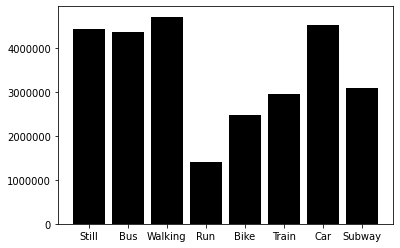

In [18]:
# Create bar plot for each label
labels = []
quantities = []
for label, trips in trips_by_label.items():
    trips_data = pd.concat(trips)
    labels.append(label)
    height, _ = trips_data.shape
    quantities.append(height)
plt.clf()
fig, ax = plt.subplots()
ax.bar(labels, quantities, color='black')
ax.ticklabel_format(style='plain', axis='y')
plt.savefig(
    f'shl-label-quantities.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()

<Figure size 432x288 with 0 Axes>

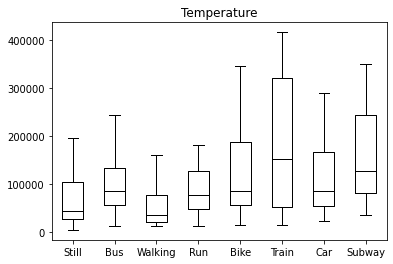

In [20]:
# Create a boxplot to show how long the trips are
# for each label
diagram_dict = OrderedDict()
for label, trips in trips_by_label.items():
    lengths = []
    for trip in trips:
        height, _ = trip.shape
        lengths.append(height)
    diagram_dict[label] = lengths
plt.clf()
fig, ax = plt.subplots()
diagram_labels, diagram_data = [*zip(*diagram_dict.items())]
bp = ax.boxplot(diagram_data, showfliers=False)
ax.set_xticks(range(1, len(diagram_labels) + 1))
ax.set_xticklabels(diagram_labels)
ax.set_title(sensor)

for element in [
    'boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps'
]:
    plt.setp(bp[element], color='black')

plt.savefig(
    f'shl-trip-lengths.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()
